In [1]:
#IMPORTING REQUIRED LIBRARIES
from pandas import Series
from pandas import concat
from pandas import read_csv
from pandas import datetime
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import MinMaxScaler
from keras.layers.core import Dense, Activation, Dropout
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from math import sqrt
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

D:\anaconda Installer\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [2]:
#LOADING THE DATASET
df=pd.read_csv("abohar_mango.csv")
df.shape

(799, 12)

In [3]:
#CHANGING TO DATETIME INDEX
df['priceDate']=pd.to_datetime(df['priceDate'])

df=df.set_index('priceDate')
df.drop(['origin','itemName','minPrice','arrivals','modalPrice','state','mandiName','unitArrivals','variety','priceUnit'],axis=1,inplace=True)



In [4]:
df.replace("NULL",np.nan)
df=df.fillna(df.mean())
df.isnull().values.any()

False

In [5]:
#SCALING OF VALUES
values=df.values

scaler = MinMaxScaler(feature_range=(-1, 1))
df=scaler.fit_transform(values)


In [6]:
def window_data(df,window_size):
    datax=[]
    datay=[]
    for i in range(len(df)-window_size):
        datax.append(df[i:(i+window_size),0])
        datay.append(df[i+window_size,0])
       
    
    return np.array(datax),np.array(datay)


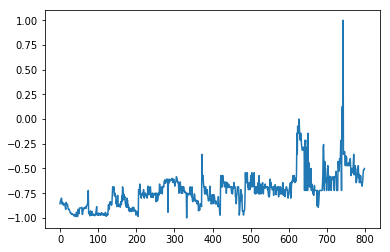

In [7]:
plt.plot(df)
plt.show()

In [8]:
#DIVIDING INTO TEST AND TRAIN
window_size=50
train_size=int(len(df)*0.80)
test_size=len(df)-train_size
train,test=df[0:train_size,:],df[train_size:len(df),:]
print(train.shape)
print(test.shape)

(639, 1)
(160, 1)


In [9]:
trainx,trainy=window_data(train,window_size)
testx,testy=window_data(test,window_size)


In [10]:
#RESHAPING AND CHECKING OF SIZE
trainx=np.reshape(trainx,(trainx.shape[0],trainx.shape[1],1))
testx=np.reshape(testx,(testx.shape[0],testx.shape[1],1))

print(trainx.shape, trainy.shape, testx.shape, testy.shape)

(589, 50, 1) (589,) (110, 50, 1) (110,)


In [11]:
#FIT THE LSTM MODEL
model = Sequential()
model.add(LSTM(32,batch_input_shape=(1, 50, 1), return_sequences=True, stateful=True))
model.add(Dropout(0.2))
model.add(LSTM(32,batch_input_shape=(1,50,1),stateful=True))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss="mse", optimizer="adam")

model.summary()


_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_1 (LSTM)                (1, 50, 32)               4352      
_________________________________________________________________
dropout_1 (Dropout)          (1, 50, 32)               0         
_________________________________________________________________
lstm_2 (LSTM)                (1, 32)                   8320      
_________________________________________________________________
dropout_2 (Dropout)          (1, 32)                   0         
_________________________________________________________________
dense_1 (Dense)              (1, 1)                    33        
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


In [12]:
import time
start = time.time()
model.fit(trainx,trainy,batch_size=1,epochs=5,validation_data=(testx, testy))
print("> Compilation Time : ", time.time() - start)

Train on 589 samples, validate on 110 samples
Epoch 1/5
589/589 [==============================] - 26s 43ms/step - loss: 0.0251 - val_loss: 0.0402
Epoch 2/5
589/589 [==============================] - 24s 42ms/step - loss: 0.0156 - val_loss: 0.0358
Epoch 3/5
589/589 [==============================] - 23s 40ms/step - loss: 0.0128 - val_loss: 0.0335
Epoch 4/5
589/589 [==============================] - 24s 41ms/step - loss: 0.0118 - val_loss: 0.0321
Epoch 5/5
589/589 [==============================] - 24s 41ms/step - loss: 0.0109 - val_loss: 0.0319
> Compilation Time :  123.00617361068726


In [13]:
#EVALUATE THE MODEL
import math
trainScore=model.evaluate(trainx,trainy,batch_size=1,verbose=0)
print('Train_MSE:',trainScore)
print('Train_RMSE:',math.sqrt(trainScore))
testScore=model.evaluate(testx,testy,batch_size=1,verbose=0)
print('Test_MSE:',testScore)
print('test_RMSE:',math.sqrt(testScore))

Train_MSE: 0.006099002250519352
Train_RMSE: 0.0780961090613313
Test_MSE: 0.03194571096837341
test_RMSE: 0.17873363132990225


In [14]:
#MAKING PREDICTIONS
look_ahead=7
trainPredict=[np.vstack([testx[-1][1:],testy[-1]])]
predictions=np.zeros((look_ahead,1))
for i in range(look_ahead):
    prediction=model.predict(np.array([trainPredict[-1]]),batch_size=32)
    predictions[i]=prediction
    trainPredict.append(np.vstack([trainPredict[-1][1:],prediction]))
    

In [15]:
#RESETTING THE STATES
model.reset_states()

In [16]:
#GETTING THE PREDICTED VALUES
predicted=scaler.inverse_transform(predictions)
predicted


array([[4187.92885542],
       [4260.75845957],
       [4302.1132946 ],
       [4326.97409391],
       [4343.11556816],
       [4354.55399752],
       [4363.38722706]])

In [17]:
predicted=pd.DataFrame(predicted)

In [18]:
predicted.to_csv('maxprice_abohar_mango_7days.csv')